### CONFIGURATION

In [12]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Hartwig imports
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import analyseVCF as aVCF

In [3]:
# BED FILE
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/70-30mixin/"
BED_FILE_NAME = "na12878-na24385-somatic-truth-regionsSORTED.bed"

# TRUTH SET
SAMPLE_NAMES_TRUTH = {'NA12878':'truth'}
VCF_PATH_TRUTH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/70-30mixin/"
VCF_FILE_NAME_TRUTH = "na12878-na24385-somatic-truth.vcf"

# COMBINED VCF CONFIG
VCF_SAMPLE = "CPCT11111111"
VCF_PATH = '/Users/peterpriestley/hmf/analyses/70-30sample/170915_regression/'
VCF_FILE_NAME = VCF_SAMPLE + "R_"+ VCF_SAMPLE + "T_post_processed.vcf"
SAMPLE_NAMES = {VCF_SAMPLE+'T':'melted'}

#VCF_FILE_NAME = VCF_SAMPLE + "R_"+ VCF_SAMPLE + "T_melted.vcf"#_somatic_filtered.vcf"#
#SAMPLE_NAMES = {VCF_SAMPLE + 'T.mutect':'mutect', VCF_SAMPLE + 'T.freebayes':'freebayes', \
#                'TUMOR.strelka':'strelka', 'TUMOR.varscan':'varscan'}

### Functions

In [4]:
def calculateTruth(df,dfTruth):
    df = pd.merge(df,dfTruth,how='left', left_index=True,right_index=True,suffixes=('', '_Truth'))
    df['hasTP'] = False
    df['hasFP'] = False
    for columnName in list(df):
        if columnName.endswith('allele') and not columnName.startswith('truth'):
            df['hasTP'] = (df['hasTP']) | ((df[columnName[:-6]+'indelDiff'] == df['truthindelDiff']) \
                    & (~pd.isnull(df['truthindelDiff']) & (df['variantType'] == 'INDEL'))) |((df[columnName] == df['truthallele']) \
                    & (df['variantType'] == 'SNP'))
            df['hasFP'] = (df['hasFP']) | ((df[columnName[:-6]+'indelDiff'] != df['truthindelDiff']) \
                    & (df['variantType'] == 'INDEL') & (df[columnName[:-6]+'indelDiff'] != '')& (~pd.isnull(df['truthallele']))) |((df[columnName] != df['truthallele']) \
                    & (df['variantType'] == 'SNP') & (df[columnName] != '')& (~pd.isnull(df['truthallele'])))
    df['Truth'] = (df['hasTP']) &  (df['hasFP'] == False)
    return df

In [5]:
def calcuatePrecisionSensivityMatrix(df):
    outputdata = []
    for columnName in list(df):
        if columnName.endswith('allele') & ~columnName.endswith('truthallele'):
            myCaller = columnName[:-6]
            variantTypes = df[(df[myCaller+'allele'] != '')].variantType.unique()
            for variantType in variantTypes:
                truePositives = len(df[(df[myCaller+'allele'] != '') & (df['Truth'] == True) &(df['variantType'] == variantType)])
                positives = len(df[(df[myCaller+'allele'] != '')&(df['variantType'] == variantType)])
                truthSet = len(dfTruth[dfTruth['variantType'] == variantType]) 
                falseNegatives = truthSet - truePositives
                if positives > 0 and truthSet > 0:
                    outputdata.append([variantType, myCaller, truthSet,truePositives,positives-truePositives, falseNegatives, \
                                   round(truePositives/float(positives),4),round(truePositives/float(truthSet),4)])
    
    outputDF = pd.DataFrame(outputdata)
    outputDF.columns = (['variantType','caller','truthSet','truePositives','falsePositives','falseNegatives','precision','sensitivity'])
    return outputDF.sort_values(['variantType','caller'])

<h3> Load VCFs and Prepare DF

In [6]:
## LOAD TRUTH SET VCF
bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
dfTruth = aVCF.loadVariantsFromVCF(VCF_PATH_TRUTH,VCF_FILE_NAME_TRUTH, \
                                   SAMPLE_NAMES_TRUTH,"Mix-in Truth Set",True,True,bed)
dfTruth = dfTruth[['chrom','pos','variantType','ref','truthallele','truthindelDiff','bedRegion']]
dfTruth = dfTruth.set_index(['chrom','pos'])

reading vcf file: na12878-na24385-somatic-truth.vcf
reading VCF File line: 1
reading VCF File line: 200001
reading VCF File line: 400001
reading VCF File line: 600001
reading VCF File line: 800001
reading VCF File line: 1000001
Number variants loaded: 1104460


In [7]:
# LOAD SAMPLE VCF + match to truth set
bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
dfProd = aVCF.loadVariantsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE,False,True,bed)
dfProd = dfProd.set_index(['chrom','pos'])
dfProd = calculateTruth(dfProd,dfTruth)

reading vcf file: CPCT11111111R_CPCT11111111T_post_processed.vcf
reading VCF File line: 1
reading VCF File line: 200001
reading VCF File line: 400001
reading VCF File line: 600001
reading VCF File line: 800001
reading VCF File line: 1000001
reading VCF File line: 1200001
Number variants loaded: 1046042


### PRECISION + SENSITIVITY|

In [8]:
outputDF = calcuatePrecisionSensivityMatrix(dfProd)
outputDF

,variantType,caller,truthSet,truePositives,falsePositives,falseNegatives,precision,sensitivity
1,INDEL,melted,96616,74432,577,22184,0.9923,0.7704
0,SNP,melted,1007844,969786,1247,38058,0.9987,0.9622


In [9]:
dftemp2 = dfProd.reset_index()
pd.pivot_table(dftemp2, values='pos', index=['filter'], columns=['variantType','Truth'], aggfunc='count')

variantType INDEL          SNP        
Truth       False  True  False   True 
filter                                
PASS          107   1796   725   25944
PON           470  72636   522  943842

<h3> Allelic Depth

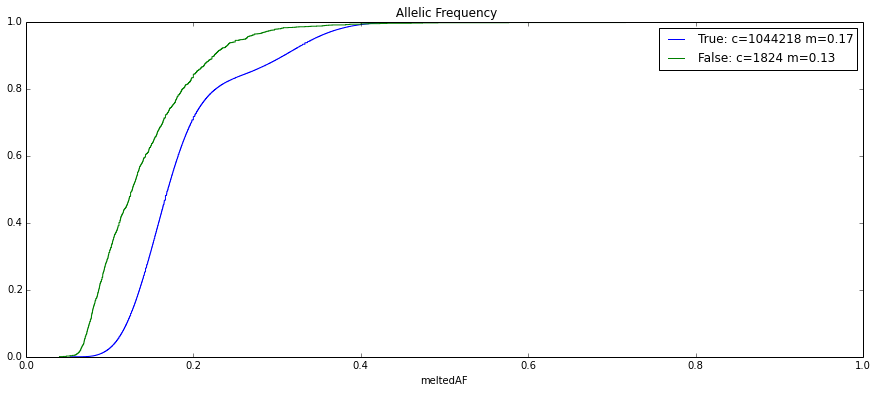

In [13]:
#Alllele Freq By Caller
for truth in [True,False]:
    ser = dfProd[dfProd.Truth==truth]['meltedAF']
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency",figsize=[15,6],xlim=[0,1])